In [38]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
# FUNCTIONS
def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return [roll, pitch, yaw]

def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def unwrap_angle(angle_array):
    unwrapped = np.copy(angle_array)
    k_now = 0
    angle_before = 0
    for i in range(len(unwrapped)):
        if ((angle_before < -2) and (unwrapped[i] > 2)):
            k_now = k_now - 1
        elif ((angle_before > 2) and (unwrapped[i] < -2)):
            k_now = k_now + 1
        angle_before = unwrapped[i]
        unwrapped[i] += (k_now * 2 *np.pi)
    return unwrapped

def reindex_value(source_val, source_idx, target_idx, target_val=None):
#     if (target_val!=None):
#         no_tval = True
#         target_val = np.copy(target_idx)
    no_tval = False
    try:
        _ = target_val.shape
    except:
        no_tval = True
        target_val = np.copy(target_idx)
    # FIND INDEX INTERSECTION
    latest_start_idx = max(source_idx[0],
                           target_idx[0])
    earliest_start_idx =min(source_idx[0],
                           target_idx[0])
    earliest_end_idx = min(source_idx[-1],
                           target_idx[-1])
    # CONVERT TO PD.DF
    source_pd = pd.DataFrame(index = source_idx,
                             data = source_val)
    target_pd = pd.DataFrame(index = target_idx,
                             data = target_val)
    # DROP DUPLICATED INDEX
    source_pd = source_pd[~source_pd.index.duplicated()]
    target_pd = target_pd[~target_pd.index.duplicated()]
    # SLICE DATA IN INTERSECTION
    source_pd = source_pd.reindex(source_pd.index.union([latest_start_idx,
                                                         earliest_end_idx])).interpolate(method='index')
    time_mask = (source_pd.index >= latest_start_idx) &\
                (source_pd.index <= earliest_end_idx)
    source_pd = source_pd.loc[time_mask]
    
    target_pd = target_pd.reindex(target_pd.index.union([latest_start_idx,
                                                         earliest_end_idx])).interpolate(method='index')
    time_mask = (target_pd.index >= latest_start_idx) &\
                (target_pd.index <= earliest_end_idx)
    target_pd = target_pd.loc[time_mask]
    # REINDEX SOURCE_VAL
    source_pd = source_pd.reindex(source_pd.index.union(target_pd.index))\
                                        .interpolate(method='index')\
                                        .reindex(target_pd.index)
    # CONVERT BACK TO NP ARRAY
    _sval = source_pd.to_numpy()
    _sidx = source_pd.index.to_numpy()
    
    if (no_tval==False):
        _tval = target_pd.to_numpy()
        _tidx = target_pd.index.to_numpy()
        return _sval, _sidx, _tidx, _tval
    else:
        return _sval, _sidx

In [68]:
# IMPORT DATA
_bagfilename = "wp_ext"
bag = rosbag.Bag(_bagfilename+".bag")
print(bag)

path:        wp_ext.bag
version:     2.0
duration:    20.6s
start:       May 27 2021 20:35:05.95 (1622122505.95)
end:         May 27 2021 20:35:26.57 (1622122526.57)
size:        2.6 MB
messages:    8296
compression: none [4/4 chunks]
types:       diagnostic_msgs/DiagnosticArray       [60810da900de1dd6ddd437c3503511da]
             dynamic_reconfigure/Config            [958f16a05573709014982821e6822580]
             dynamic_reconfigure/ConfigDescription [757ce9d44ba8ddd801bb30bc456f946f]
             geometry_msgs/TwistStamped            [98d34b0043a2093cf9d9345ab6eef12e]
             golfi/ukf_states                      [38d0f35cc2cbdd4f2de2e8d12d845144]
             nav_msgs/Odometry                     [cd5e73d190d741a2f92e81eda573aca7]
             rosgraph_msgs/Log                     [acffd30cd6b6de30f120938c17c593fb]
             sensor_msgs/Imu                       [6a62c6daae103f4ff57a132d6f95cec2]
             sensor_msgs/NavSatFix                 [2d3a8cd499b9b4a0249fb98fd

In [69]:
# PERIKSA FORMAT PESAN
_bagdata = []
for topic, msg, t in bag.read_messages(topics=['/ukf_states']):
    _bagdata.append([msg, t.to_sec()])
print(_bagdata[200])

[stamp: 
  secs: 1622122510
  nsecs: 172419153
x: 784343.2760223027
y: 9239769.209059622
vx: -1.5995068550109863
vy: 0.27976709604263306
vx_gnss: -1.7087809043005109
vy_gnss: 0.15027503482997417
v_gnss: 1.715375983566058
v_tach: 0.0
yaw_est: -2.54636287689209
yaw_imu: 2.1668262481689453
yaw_dydx: 3.05387544631958, 1622122510.172603]


In [70]:
# AMBIL PESAN UKF
ukf_t = []
ukf_xy = []
ukf_yaw_est = []
ukf_yaw_imu = []
ukf_yaw_dydx = []
for topic, msg, t in bag.read_messages(topics=['/ukf_states']):
    ukf_t.append(t.to_sec())
    ukf_xy.append([msg.x, msg.y])
    ukf_yaw_est.append(msg.yaw_est)
    ukf_yaw_imu.append(msg.yaw_imu)
    ukf_yaw_dydx.append(msg.yaw_dydx)
ukf_t = np.array(ukf_t)
ukf_xy = np.array(ukf_xy)
ukf_yaw_est = np.array(ukf_yaw_est)
ukf_yaw_imu = np.array(ukf_yaw_imu)
ukf_yaw_dydx = np.array(ukf_yaw_dydx)
print(ukf_xy[:3])

[[ 784348.21217998 9239768.53187799]
 [ 784348.20736163 9239768.53251071]
 [ 784348.20246758 9239768.53309793]]


# bypass ukf

In [71]:
# _wp = np.load("wp_3nov_l_6nov.npy")
# ukf_xy = _wp[:,:2]
# ukf_yaw_est = _wp[:,2]
# ukf_v_o = _wp[:,3]
# ukf_cvtr_o = _wp[:,4]

# Scipy Interpolation

In [72]:
###### XY (POSITION) #########
# ref: https://scipy-cookbook.readthedocs.io/items/Interpolation.html
from scipy.interpolate import splprep, splev

# ukf data
ukf_r = np.sqrt((ukf_xy[1:,0]-ukf_xy[:-1,0])**2 + (ukf_xy[1:,1]-ukf_xy[:-1,1])**2)
ukf_r = np.append(ukf_r, ukf_r[-1])
ukf_r_sum = np.sum(ukf_r)
ukf_r_int = np.array([0.])
for i in range(len(ukf_r)-1):
    ukf_r_int = np.append(ukf_r_int, ukf_r_int[i]+ukf_r[i])

# scp (scipy b-spline interpolation)
INTERPOINT_DIST = 0.1 #10cm
scp_point_num = int(ukf_r_sum / INTERPOINT_DIST) # total dist/interpoint dist
s=20.0 # smoothness parameter
k=2 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)
tckp,u = splprep([ukf_xy[:,0], ukf_xy[:,1]], s=s, k=k, nest=nest) # find the knot points
scp_x, scp_y = splev(np.linspace(0,1,scp_point_num), tckp) # evaluate spline, including interpolated points
scp_r = np.sqrt((scp_x[1:]-scp_x[:-1])**2 + (scp_y[1:]-scp_y[:-1])**2)
scp_r = np.append(scp_r, scp_r[-1])
scp_r_sum = np.sum(scp_r)
scp_r_int = np.array([0.])
for i in range(len(scp_r)-1):
    scp_r_int = np.append(scp_r_int, scp_r_int[i]+scp_r[i])

## scp_n (regularize interpoint distance via reindex_value)
scp_x_n, _ = reindex_value(scp_x, scp_r_int, np.linspace(0, scp_r_sum, int(scp_r_sum/INTERPOINT_DIST)))
scp_y_n, _ = reindex_value(scp_y, scp_r_int, np.linspace(0, scp_r_sum, int(scp_r_sum/INTERPOINT_DIST)))
scp_x_n = np.reshape(scp_x_n, (-1))
scp_y_n = np.reshape(scp_y_n, (-1))
scp_r_n = np.sqrt((scp_x_n[1:]-scp_x_n[:-1])**2 + (scp_y_n[1:]-scp_y_n[:-1])**2)
scp_r_n = np.append(scp_r_n, scp_r_n[-1])
scp_r_n_int = np.array([0.])
for i in range(len(scp_r_n)-1):
    scp_r_n_int = np.append(scp_r_n_int, scp_r_n_int[i]+scp_r_n[i])

In [73]:
# SLICE (to remove bad start/end points)
s,e = 0,-1
scp_x = scp_x[s:e]
scp_y = scp_y[s:e]
scp_r = scp_r[s:e]
scp_r_int = scp_r_int[s:e]

s,e = 0,-3
scp_x_n = scp_x_n[s:e]
scp_y_n = scp_y_n[s:e]
scp_r_n = scp_r_n[s:e]
scp_r_n_int = scp_r_n_int[s:e]

In [74]:
####### YAW ######
scp_yaw = np.arctan2(scp_y[1:]-scp_y[:-1], scp_x[1:]-scp_x[:-1])
scp_yaw = np.append(scp_yaw, scp_yaw[-1])
#scp_yaw += -5.87 #yaw
scp_yaw = wrap_angle(scp_yaw)

scp_yaw_n = np.arctan2(scp_y_n[1:]-scp_y_n[:-1], scp_x_n[1:]-scp_x_n[:-1])
scp_yaw_n = np.append(scp_yaw_n, scp_yaw_n[-1])
#scp_yaw_n += -5.87
scp_yaw_n = wrap_angle(scp_yaw_n)

In [75]:
###### CURVATURE #######

ukf_cvtr = unwrap_angle(ukf_yaw_est)[1:] - unwrap_angle(ukf_yaw_est)[:-1]
ukf_cvtr = np.append(ukf_cvtr, ukf_cvtr[-1])
ukf_cvtr = ukf_cvtr/(ukf_r+10e-10)

scp_cvtr = unwrap_angle(scp_yaw)[1:] - unwrap_angle(scp_yaw)[:-1]
scp_cvtr = np.append(scp_cvtr, scp_cvtr[-1])
scp_cvtr = scp_cvtr/(scp_r+10e-10)

scp_cvtr_n = unwrap_angle(scp_yaw_n)[1:] - unwrap_angle(scp_yaw_n)[:-1]
scp_cvtr_n = np.append(scp_cvtr_n, scp_cvtr_n[-1])
scp_cvtr_n = scp_cvtr_n/(scp_r_n+10e-10)

In [76]:
####### VELOCITY ########
v0 = 0.75 #m/s ~ 1.8 km/jam
vstop = 0.15
vmax = 0.75 #m/s ~ 5.4 km/jam
accel = 0.005 #m/s2
const = 7. #curvature parameter
TOTAL_STOP_DIST = 1 # meter
START_DECELERATION_DIST = 8 # meter

# ukf
num = ukf_cvtr.shape[0]
ukf_v = [v0]
for i in range(1, num):
    ukf_v.append(min(np.sqrt(ukf_v[-1]**2 + 2*accel*INTERPOINT_DIST), vmax / (1 + const*ukf_cvtr[i]**2)))
ukf_v = np.array(ukf_v)
for i in range(num):
    if ukf_r_int[-1] - ukf_r_int[i] < TOTAL_STOP_DIST:
        ukf_v[i] = 0.0
    elif ukf_r_int[-1] - ukf_r_int[i] < START_DECELERATION_DIST:
        ukf_v[i] = max(np.sqrt(max(ukf_v[i-1]**2 - 2*accel*INTERPOINT_DIST, 0.0)), vstop)

# scp
num = scp_cvtr.shape[0]
scp_v = [v0]
for i in range(1, num):
    scp_v.append(min(np.sqrt(scp_v[-1]**2 + 2*accel*INTERPOINT_DIST), vmax / (1 + const*scp_cvtr[i]**2)))
scp_v = np.array(scp_v)
for i in range(num):
    if scp_r_int[-1] - scp_r_int[i] < TOTAL_STOP_DIST:
        scp_v[i] = 0.0
    elif scp_r_int[-1] - scp_r_int[i] < START_DECELERATION_DIST:
        scp_v[i] = max(np.sqrt(max(scp_v[i-1]**2 - 2*accel*INTERPOINT_DIST, 0.0)), vstop)

# scp_n
num = scp_cvtr_n.shape[0]
scp_v_n = [v0]
for i in range(1, num):
    scp_v_n.append(min(np.sqrt(scp_v_n[-1]**2 + 2*accel*INTERPOINT_DIST), vmax / (1 + const*scp_cvtr_n[i]**2)))
scp_v_n = np.array(scp_v_n)
for i in range(num):
    if scp_r_n_int[-1] - scp_r_n_int[i] < TOTAL_STOP_DIST:
        scp_v_n[i] = 0.0
    elif scp_r_n_int[-1] - scp_r_n_int[i] < START_DECELERATION_DIST:
        scp_v_n[i] = max(np.sqrt(max(scp_v_n[i-1]**2 - 2*accel*INTERPOINT_DIST, 0.0)), vstop)

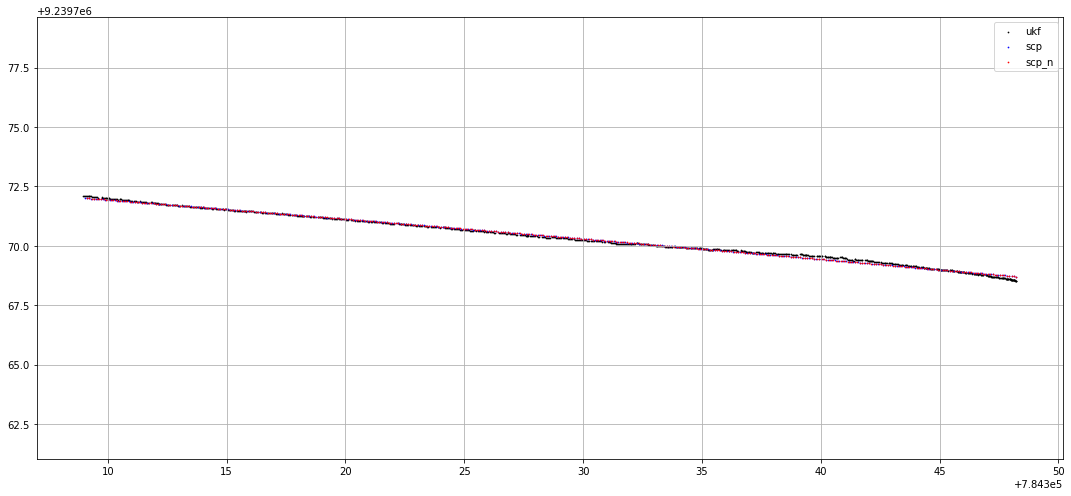

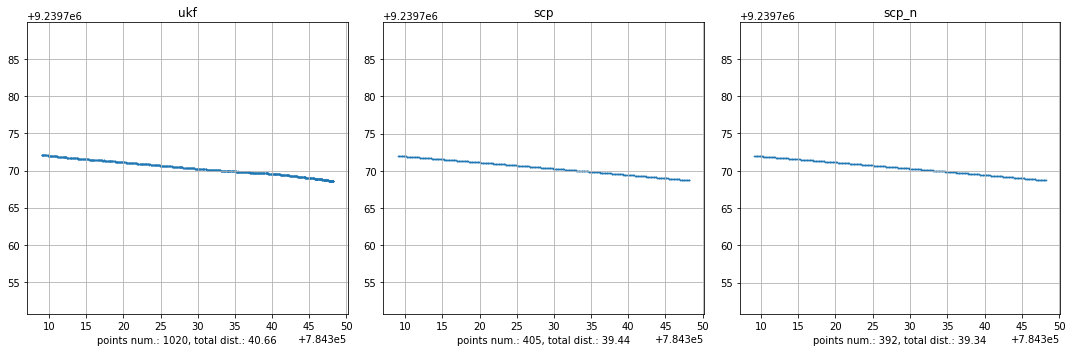

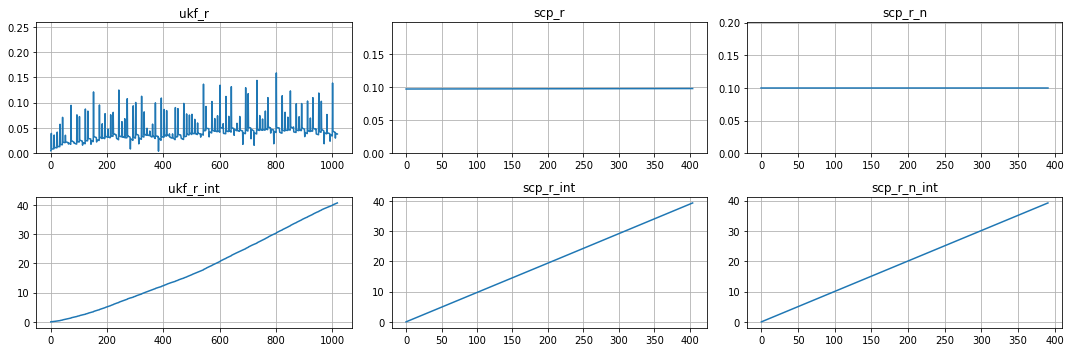

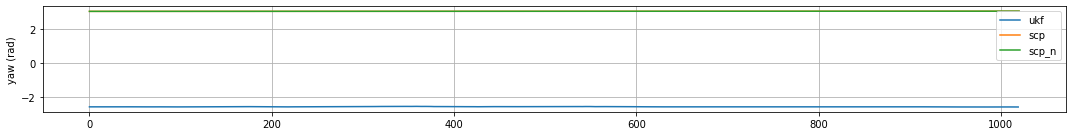

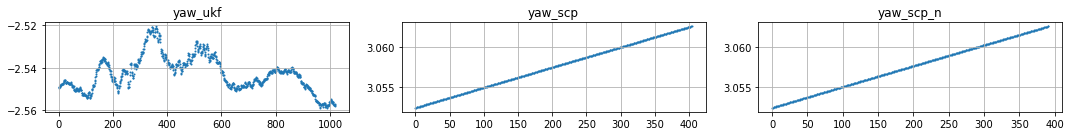

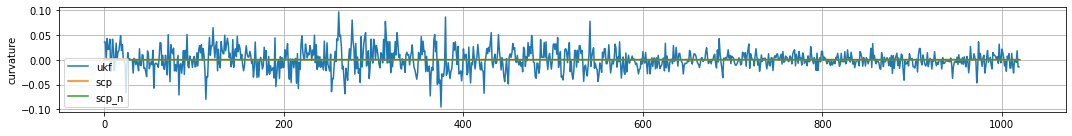

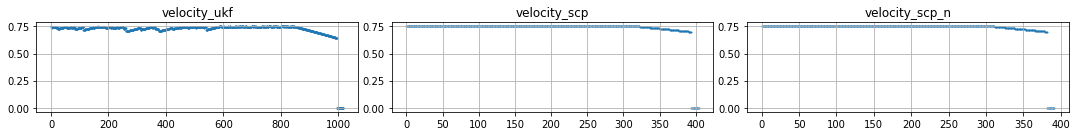

In [77]:
# PLOT

# XY
plt.figure(figsize=(15,7))
plt.scatter(ukf_xy[:,0], ukf_xy[:,1], s=0.5, label="ukf", c="black")
plt.scatter(scp_x, scp_y, s=0.5, label="scp", c="blue")
plt.scatter(scp_x_n, scp_y_n, s=0.5, label="scp_n", c="red")
plt.axis("equal")
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(ukf_xy[:,0], ukf_xy[:,1], s=0.5)
plt.axis("equal")
plt.title("ukf")
plt.xlabel("points num.: {}, total dist.: {:0.2f}".format(len(ukf_xy), np.sum(ukf_r)))
plt.grid()

plt.subplot(132)
plt.scatter(scp_x, scp_y, s=0.5)
plt.axis("equal")
plt.title("scp")
plt.xlabel("points num.: {}, total dist.: {:0.2f}".format(len(scp_x), np.sum(scp_r)))
plt.grid()

plt.subplot(133)
plt.scatter(scp_x_n, scp_y_n, s=0.5)
plt.axis("equal")
plt.title("scp_n")
plt.xlabel("points num.: {}, total dist.: {:0.2f}".format(len(scp_x_n), np.sum(scp_r_n)))
plt.grid()

plt.tight_layout()


plt.figure(figsize=(15,5))

plt.subplot(231)
plt.plot(ukf_r)
plt.title("ukf_r")
plt.ylim(0, np.max(ukf_r)+0.1)
plt.grid()

plt.subplot(232)
plt.plot(scp_r)
plt.title("scp_r")
plt.ylim(0, np.max(scp_r)+0.1)
plt.grid()

plt.subplot(233)
plt.plot(scp_r_n)
plt.title("scp_r_n")
plt.ylim(0, np.max(scp_r_n)+0.1)
plt.grid()

plt.subplot(234)
plt.plot(ukf_r_int)
plt.title("ukf_r_int")
plt.grid()

plt.subplot(235)
plt.plot(scp_r_int)
plt.title("scp_r_int")
plt.grid()

plt.subplot(236)
plt.plot(scp_r_n_int)
plt.title("scp_r_n_int")
plt.grid()

plt.tight_layout()


# YAW
plt.figure(figsize=(15,2))
plt.plot(unwrap_angle(ukf_yaw_est), label="ukf")
plt.plot(np.linspace(0,len(ukf_yaw_est),len(scp_yaw)), unwrap_angle(scp_yaw), label="scp")
plt.plot(np.linspace(0,len(ukf_yaw_est),len(scp_yaw_n)), unwrap_angle(scp_yaw_n), label="scp_n")
plt.legend()
plt.grid()
plt.ylabel("yaw (rad)")
plt.tight_layout()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.scatter(range(len(ukf_yaw_est)), ukf_yaw_est, s=1)
plt.title("yaw_ukf")
plt.grid()

plt.subplot(132)
plt.scatter(range(len(scp_yaw)), scp_yaw, s=1)
plt.title("yaw_scp")
plt.grid()

plt.subplot(133)
plt.scatter(range(len(scp_yaw_n)), scp_yaw_n, s=1)
plt.title("yaw_scp_n")
plt.grid()

plt.tight_layout()


# CURVATURE
plt.figure(figsize=(15,2))
# plt.plot(ukf_cvtr_o, label="ukf")
plt.plot(ukf_cvtr, label="ukf")
plt.plot(np.linspace(0, len(ukf_cvtr), len(scp_cvtr[:-50])), scp_cvtr[:-50], label="scp")
plt.plot(np.linspace(0, len(ukf_cvtr), len(scp_cvtr_n[:-50])), scp_cvtr_n[:-50], label="scp_n")
plt.legend()
plt.ylabel("curvature")
plt.grid()
plt.tight_layout()

# VELOCITY
plt.figure(figsize=(15,2))
plt.subplot(131)
# plt.scatter(range(len(ukf_v_o)), ukf_v_o, s=1)
plt.scatter(range(len(ukf_v)), ukf_v, s=1)
plt.title("velocity_ukf")
plt.grid()

plt.subplot(132)
plt.scatter(range(len(scp_v)), scp_v, s=1)
plt.title("velocity_scp")
plt.grid()

plt.subplot(133)
plt.scatter(range(len(scp_v_n)), scp_v_n, s=1)
plt.title("velocity_scp_n")
plt.grid()

plt.tight_layout()

In [78]:
wp_scp_n = np.hstack((np.reshape(scp_x_n, (-1,1)),
                      np.reshape(scp_y_n, (-1,1)),
                      np.reshape(scp_yaw_n, (-1,1)),
                      np.reshape(scp_v_n, (-1,1)),
                      np.reshape(scp_cvtr_n, (-1,1))))
wp_scp_n[-1]

array([7.84309126e+05, 9.23977200e+06, 3.06261013e+00, 0.00000000e+00,
       0.00000000e+00])

In [79]:
wp_ukf = np.hstack((np.reshape(ukf_xy[:,0], (-1,1)),
                    np.reshape(ukf_xy[:,1], (-1,1)),
                    np.reshape(ukf_yaw_est, (-1,1)),
                    np.reshape(ukf_v, (-1,1)),
                    np.reshape(ukf_cvtr, (-1,1))))

wp_ukf[10]

array([ 7.84348106e+05,  9.23976855e+06, -2.54775858e+00,  7.41728646e-01,
        2.02687622e-02])

Save wp

In [80]:
np.save(_bagfilename+".npy", wp_ukf)

In [81]:
## SELISIH YAW UKF DAN GEOMETRIK (GNSS)
# np.rad2deg(ukf_yaw_est[0] - scp_yaw_n[0])
np.rad2deg(np.mean(ukf_yaw_est) - np.mean(scp_yaw_n))

-320.8693893880614

In [37]:
print(ukf_yaw_est.shape)
print(scp_yaw_n.shape)

(1183,)
(375,)


In [32]:
wrap_angle(-1.3131918907165527 - np.pi/2)

-2.8839882175114493